In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Creating custom legend handles
import matplotlib.lines as mlines
import sys
import os
import re
from tqdm import tqdm

def path_link(path:str):
    sys.path.append(path)

path_link('/home/jpierre/v2/lib')

import utils2.testing_gen as gen
import utils2.loading as load
import utils2.nn_gen as nn_gen
from utils2.tools import array2List

from NNSimulator import genSim, getSimulationData


from norm import normalizeGraph

from measure import Param_eval, EvaluationCfg, evaluateLoad, saveLoader


yessss sir
>>>>>>>>>>>> LOADOING THE V2 OF FEATURES
fndjngkjdfs --NN-sim
update


In [2]:
def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)

    return errorAngle, errorNorm

In [3]:
import stats.stats_re as stats
import yaml

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

PATH = ['/home/jpierre/v2/results_end/files/simplest']
MODEL_PATH = '/home/jpierre/v2/results_end/models'
MODEL = 'simplest'

In [5]:
def loadModel(modelName:str, d, path = MODEL_PATH):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    #model = loadFun.loadNetwork(inputShape, edges_shape)
    model = loadFun.loadNetwork(d)

    return model


In [6]:
def getModel(cfg, std_path, device = DEVICE, model_path = MODEL_PATH):

    with open(cfg, 'r') as file:
        cfg = yaml.safe_load(file) 

    trainingInfos = cfg['training']

    d_model = trainingInfos['cfg_mod'][f'{trainingInfos["cfg_mod"]["model_name"]}']


    model = loadModel(MODEL, d_model, model_path)



    state_dict = torch.load(std_path, map_location = 'cpu')

    model.load_state_dict(state_dict)

    model.eval()

    model = model.to(device)

    return model

    

In [7]:
class id():
    def __init__(self):
        self.dropout = None
        self.l1 = None
        self.path = None
        self.loss = None
        self.eval_loss = None
        self.eval_sim_loss = None
        self.data_type = None
        self.action_r = None
        self.cfg = None


    def load_id(self, path:str):
        try:
            if 'scaleL1' in path:
                nb_layer_match = re.search(r'scaleL1-(\d+\.\d+|\d+)', path)
                self.l1 = float(nb_layer_match.group(1))
            dropout_match = re.search(r'dropout-(\d+)', path)


            if 'action' in path:
                self.action_r = 1
            else:
                0



            self.dropout = int(dropout_match.group(1))

            if 'noisy' in path:
                self.data_type = 'noisy'

            elif 'normal' in path:
                self.data_type = 'normal'
            
            
            self.path = path

            self.loss = os.path.join(os.path.dirname(path), 'loss_list.npy')
            self.eval_loss = os.path.join(os.path.dirname(path), 'eval_list.npy')
            self.eval_sim_loss = os.path.join(os.path.dirname(path), 'eval_sim_list.npy')
            self.cfg = os.path.join(os.path.dirname(os.path.dirname(path)), 'cfg.yml')
        except:
            print(path)

    def label(self):
        return f'{self.data_type}_action-{self.action_r}_dropout{self.dropout}_l1-{self.l1}'
    

def get_path_models(path):

    res = []

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('best.pt'):
                id_model = id()
                id_model.load_id(os.path.join(root, file))

                res.append(id_model)


    return res




res = []

for path in PATH:
    res.extend(get_path_models(path))

In [8]:
for r in res:
    print(f'{r.path} >>> {r.__dict__}')

/home/jpierre/v2/results_end/files/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/simplest_best.pt >>> {'dropout': 0, 'l1': 0.0001, 'path': '/home/jpierre/v2/results_end/files/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/simplest_best.pt', 'loss': '/home/jpierre/v2/results_end/files/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/loss_list.npy', 'eval_loss': '/home/jpierre/v2/results_end/files/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/eval_list.npy', 'eval_sim_loss': '/home/jpierre/v2/results_end/files/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/eval_sim_list.npy', 'data_type': 'noisy', 'action_r': None, 'cfg': '/home/jpierre/v2/results_end/files/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/cfg.yml'}
/home/jpierre/v2/results_end/files/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-1/model_trained/simplest_best.pt >>> {'dropout': 1, 'l1': 0.0001, 'path': '/home/jpierre/v2/re

# =====================

In [9]:
normal_runs = []
noisy_runs = []


for r in res:
    if r.data_type == 'normal':
        normal_runs.append(r)
    elif r.data_type == 'noisy':
        noisy_runs.append(r)
        
        
        
normal_models_l1 = []
normal_l1_val = []

noisy_models_l1 = []
noisy_l1_val = []


for r in normal_runs:
    if r.data_type == 'normal':
        if r.dropout == 0:
            l1_val = r.l1
            normal_l1_val.append(l1_val)


            normal_models_l1.append(r)



for r in noisy_runs:
    if r.data_type == 'noisy':
        if r.dropout == 0:
            l1_val = r.l1
            noisy_l1_val.append(l1_val)


            noisy_models_l1.append(r)


# ===================

In [10]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 1000


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


data_gt_1  = gen.get_mult_data(params1, NB_SIM)
graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
data_gt_list_1 = array2List(data_gt_1)


#data_gt_2 = gen.get_mult_data(params2, NB_SIM)
#graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
#data_gt_list_2 = array2List(data_gt_2)

0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:47<00:00, 21.06it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:45<00:00, 22.19it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:43<00:00, 22.96it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:25<00:00, 39.88it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:23<00:00, 42.81it/s]


In [11]:
start = 250
length = 100

stop = start+length

In [12]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_normal = stats.MSD_stat(data_gt_1[:, start:stop])
RDF_base_normal  = stats.apply_rdf(data_gt_1[:, start:stop])
SCAT_base_normal = stats.applySelfScattering(data_gt_1[:, start:stop])
DISTR_base_normal = stats.apply_hist(data_gt_1, a, b)
SUM_base_normal = stats.sumSpeeds(data_gt_1[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:01<00:00, 80.63it/s]


In [13]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
#p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:00,  3.79it/s]


In [14]:
MSD_list_normal = []
RDF_list_normal = []
SCAT_list_normal = []
DISTR_list_normal = []
SUM_list_normal = []
MSE_rollout = []

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []




for i in tqdm(range(len(normal_models_l1))):

    ## load model
    cfg = normal_models_l1[i].cfg
    std_path = normal_models_l1[i].path
    model = getModel(cfg, std_path)


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_1, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_1.copy()[:, start:stop])



    MSD_list_normal.append(msd)
    RDF_list_normal.append(rdf)
    SCAT_list_normal.append(scat)
    DISTR_list_normal.append(speed_distr)
    SUM_list_normal.append(sum_speed)
    
    
    
    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))


  0%|          | 0/5 [00:00<?, ?it/s]

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 181.19it/s]

100%|██████████| 99/99 [00:00<00:00, 256.22it/s]

100%|██████████| 99/99 [00:00<00:00, 249.79it/s]

100%|██████████| 99/99 [00:00<00:00, 268.69it/s]

100%|██████████| 99/99 [00:00<00:00, 236.15it/s]

100%|██████████| 100/100 [00:01<00:00, 69.69it/s][A

100%|██████████| 100/100 [00:01<00:00, 69.14it/s][A

100%|██████████| 100/100 [00:01<00:00, 74.23it/s][A

100%|██████████| 100/100 [00:01<00:00, 66.52it/s][A

100%|██████████| 100/100 [00:01<00:00, 79.04it/s][A

 47%|████▋     | 73/155 [00:51<01:10,  1.17it/s]


100%|██████████| 155/155 [02:41<00:00,  1.55it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 277.60it/s]

100%|██████████| 15/15 [00:00<00:00, 270.10it/s]

100%|██████████| 15/15 [00:00<00:00, 277.01it/s]

100%|██████████| 15/15 [00:00<00:00, 309.58it/s]

100%|██████████| 15/15 [00:00<00:00, 297.86it/s]

100%|██████████| 15/15 [00:00<00:00, 296.79it/s]

100%|██████████| 15/15 [00:00<00:00, 302.99it/s]

100%|██████████| 15/15 [00:00<00:00, 287.43it/s]

100%|██████████| 15/15 [00:00<00:00, 248.08it/s]

100%|██████████| 15/15 [00:00<00:00, 257.53it/s]

100%|██████████| 15/15 [00:00<00:00, 258.88it/s]

100%|██████████| 15/15 [00:00<00:00, 302.02it/s]

100%|██████████| 15/15 [00:00<00:00, 259.54it/s]

100%|██████████| 15/15 [00:00<00:00, 251.90it/s]

100%|██████████| 15/15 [00:00<00:00, 303.39it/s]

100%|██████████| 15/15 [00:00<00:00, 298.96it/s]

100%|██████████| 15/15 [00:00<00:00, 299.54it/s]

100%|██████████| 15/15 [00:00<00:00, 263.52it/s]



>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 278.84it/s]

100%|██████████| 99/99 [00:00<00:00, 231.17it/s]

100%|██████████| 99/99 [00:00<00:00, 253.79it/s]

100%|██████████| 99/99 [00:00<00:00, 242.01it/s]

100%|██████████| 99/99 [00:00<00:00, 272.04it/s]

100%|██████████| 100/100 [00:01<00:00, 72.01it/s][A

100%|██████████| 100/100 [00:01<00:00, 70.88it/s]

100%|██████████| 100/100 [00:01<00:00, 66.91it/s][A

100%|██████████| 100/100 [00:01<00:00, 75.72it/s][A

100%|██████████| 100/100 [00:01<00:00, 68.12it/s]

 46%|████▌     | 71/155 [01:40<01:55,  1.38s/it]


100%|██████████| 155/155 [02:40<00:00,  1.69it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 253.93it/s]

100%|██████████| 15/15 [00:00<00:00, 253.93it/s]

100%|██████████| 15/15 [00:00<00:00, 254.92it/s]

100%|██████████| 15/15 [00:00<00:00, 271.30it/s]

100%|██████████| 15/15 [00:00<00:00, 250.92it/s]

100%|██████████| 15/15 [00:00<00:00, 241.47it/s]

100%|██████████| 15/15 [00:00<00:00, 271.48it/s]

100%|██████████| 15/15 [00:00<00:00, 256.18it/s]

100%|██████████| 15/15 [00:00<00:00, 258.55it/s]

100%|██████████| 15/15 [00:00<00:00, 242.74it/s]

100%|██████████| 15/15 [00:00<00:00, 277.53it/s]

100%|██████████| 15/15 [00:00<00:00, 265.33it/s]

100%|██████████| 15/15 [00:00<00:00, 299.23it/s]

100%|██████████| 15/15 [00:00<00:00, 309.39it/s]

100%|██████████| 15/15 [00:00<00:00, 241.84it/s]

100%|██████████| 15/15 [00:00<00:00, 271.28it/s]

100%|██████████| 15/15 [00:00<00:00, 298.78it/s]

100%|██████████| 15/15 [00:00<00:00, 296.78it/s]



>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 270.98it/s]

100%|██████████| 99/99 [00:00<00:00, 242.90it/s]

100%|██████████| 99/99 [00:00<00:00, 279.91it/s]

100%|██████████| 99/99 [00:00<00:00, 244.10it/s]

100%|██████████| 99/99 [00:00<00:00, 242.68it/s]

100%|██████████| 100/100 [00:01<00:00, 73.71it/s][A

100%|██████████| 100/100 [00:01<00:00, 71.32it/s]

100%|██████████| 100/100 [00:01<00:00, 72.45it/s][A

100%|██████████| 100/100 [00:01<00:00, 78.27it/s][A

100%|██████████| 100/100 [00:01<00:00, 79.31it/s][A

 48%|████▊     | 74/155 [01:41<01:12,  1.11it/s]


100%|██████████| 155/155 [02:39<00:00,  1.73it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 259.17it/s]

100%|██████████| 15/15 [00:00<00:00, 261.76it/s]

100%|██████████| 15/15 [00:00<00:00, 242.87it/s]

100%|██████████| 15/15 [00:00<00:00, 270.19it/s]

100%|██████████| 15/15 [00:00<00:00, 259.64it/s]

100%|██████████| 15/15 [00:00<00:00, 259.08it/s]

100%|██████████| 15/15 [00:00<00:00, 257.79it/s]

100%|██████████| 15/15 [00:00<00:00, 258.29it/s]

100%|██████████| 15/15 [00:00<00:00, 255.35it/s]

100%|██████████| 15/15 [00:00<00:00, 251.01it/s]

100%|██████████| 15/15 [00:00<00:00, 281.32it/s]

100%|██████████| 15/15 [00:00<00:00, 303.80it/s]

100%|██████████| 15/15 [00:00<00:00, 297.65it/s]

100%|██████████| 15/15 [00:00<00:00, 297.61it/s]

100%|██████████| 15/15 [00:00<00:00, 305.63it/s]

100%|██████████| 15/15 [00:00<00:00, 312.67it/s]

100%|██████████| 15/15 [00:00<00:00, 253.96it/s]

100%|██████████| 15/15 [00:00<00:00, 298.45it/s]



>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 287.53it/s]

100%|██████████| 99/99 [00:00<00:00, 315.97it/s]

100%|██████████| 99/99 [00:00<00:00, 322.60it/s]

100%|██████████| 99/99 [00:00<00:00, 261.73it/s]

100%|██████████| 99/99 [00:00<00:00, 270.49it/s]

100%|██████████| 100/100 [00:01<00:00, 62.29it/s][A

100%|██████████| 100/100 [00:01<00:00, 63.29it/s]

100%|██████████| 100/100 [00:01<00:00, 63.16it/s][A

100%|██████████| 100/100 [00:01<00:00, 73.18it/s][A

100%|██████████| 100/100 [00:01<00:00, 65.16it/s][A

 44%|████▍     | 68/155 [01:12<01:24,  1.03it/s]


100%|██████████| 155/155 [02:38<00:00,  1.27it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 273.08it/s]

100%|██████████| 15/15 [00:00<00:00, 261.72it/s]

100%|██████████| 15/15 [00:00<00:00, 277.32it/s]

100%|██████████| 15/15 [00:00<00:00, 271.76it/s]

100%|██████████| 15/15 [00:00<00:00, 273.07it/s]

100%|██████████| 15/15 [00:00<00:00, 276.88it/s]

100%|██████████| 15/15 [00:00<00:00, 276.80it/s]

100%|██████████| 15/15 [00:00<00:00, 275.37it/s]

100%|██████████| 15/15 [00:00<00:00, 276.79it/s]

100%|██████████| 15/15 [00:00<00:00, 263.97it/s]

100%|██████████| 15/15 [00:00<00:00, 276.35it/s]

100%|██████████| 15/15 [00:00<00:00, 137.12it/s]

100%|██████████| 15/15 [00:00<00:00, 274.33it/s]

100%|██████████| 15/15 [00:00<00:00, 275.65it/s]

100%|██████████| 15/15 [00:00<00:00, 167.10it/s]

100%|██████████| 15/15 [00:00<00:00, 119.79it/s]

100%|██████████| 15/15 [00:00<00:00, 256.43it/s]

100%|██████████| 15/15 [00:00<00:00, 75.95it/s][A


>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 254.08it/s]

100%|██████████| 99/99 [00:00<00:00, 196.41it/s]

100%|██████████| 99/99 [00:00<00:00, 141.52it/s]

100%|██████████| 99/99 [00:00<00:00, 264.20it/s]

100%|██████████| 99/99 [00:00<00:00, 201.96it/s]

100%|██████████| 100/100 [00:01<00:00, 51.06it/s][A

100%|██████████| 100/100 [00:02<00:00, 40.72it/s][A

100%|██████████| 100/100 [00:02<00:00, 46.03it/s][A

100%|██████████| 100/100 [00:02<00:00, 36.75it/s][A

100%|██████████| 100/100 [00:02<00:00, 39.28it/s][A

 24%|██▍       | 37/155 [00:52<01:49,  1.08it/s]


100%|██████████| 155/155 [02:23<00:00,  1.43it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 332.84it/s]

100%|██████████| 15/15 [00:00<00:00, 317.49it/s]

100%|██████████| 15/15 [00:00<00:00, 320.50it/s]

100%|██████████| 15/15 [00:00<00:00, 330.82it/s]

100%|██████████| 15/15 [00:00<00:00, 325.42it/s]

100%|██████████| 15/15 [00:00<00:00, 319.15it/s]

100%|██████████| 15/15 [00:00<00:00, 276.98it/s]

100%|██████████| 15/15 [00:00<00:00, 329.26it/s]

100%|██████████| 15/15 [00:00<00:00, 349.91it/s]

100%|██████████| 15/15 [00:00<00:00, 268.69it/s]

100%|██████████| 15/15 [00:00<00:00, 270.59it/s]

100%|██████████| 15/15 [00:00<00:00, 282.39it/s]

100%|██████████| 15/15 [00:00<00:00, 283.25it/s]

100%|██████████| 15/15 [00:00<00:00, 288.48it/s]

100%|██████████| 15/15 [00:00<00:00, 279.73it/s]

100%|██████████| 15/15 [00:00<00:00, 246.32it/s]

100%|██████████| 15/15 [00:00<00:00, 286.70it/s]

100%|██████████| 15/15 [00:00<00:00, 273.89it/s]



In [15]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.005590893435295732, 0.004757734024061949, 0.0021585098586872353, 0.0034007011278266975, 0.0024941504635958476]
errors std ==> [0.004854052779943458, 0.003916461743975042, 0.002424102688884978, 0.003307098742942889, 0.0025166021366825452]
angle_error ==>  [0.08289104, 0.07937862, 0.05119962, 0.08054757, 0.059549097]
angle_std std ==> [0.08289104, 0.07937862, 0.05119962, 0.08054757, 0.059549097]
norm_errors_list ==>  [0.008372735232114792, 0.007215334102511406, 0.002538524568080902, 0.0043992167338728905, 0.003654133528470993]
norm_errors_std_list std ==> [0.005844076889000419, 0.004773345203369432, 0.002995528537248525, 0.0040973133995568, 0.002892555904352014]
sim_error_list ==>  [0.10119789864993542, 0.08720430265321868, 0.04848721840531173, 0.07311404206389542, 0.053426408178896344]
sim_error_std_list std ==> [0.0023014706517775615, 0.0019962370043976416, 0.0021621755487400535, 0.0013501967862910023, 0.0014648808547758996]


# ======================

In [16]:
l1 = [normal_models_l1[i].l1 for i in range(len(normal_models_l1))]

print(l1)

[0.0001, 0.001, 0.01, 1.0, None]


In [17]:
l1[-1] = '0.0001 - action-reaction'

In [18]:
colors = ['blue', 'green', 'orange', 'red', 'purple']


In [19]:
limit_msd = 99
limit_scat = 99


In [20]:
print(l1)

[0.0001, 0.001, 0.01, 1.0, '0.0001 - action-reaction']


In [21]:
res_msd = []

(5, 99)
(5, 99)
(5, 99)
(5, 99)
(5, 99)


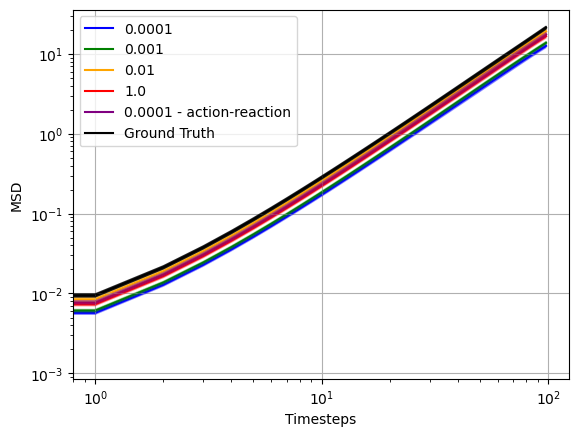

In [22]:
# plot of MSD


for i in range(len(l1)):
    print(MSD_list_normal[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_normal[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_normal[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], zorder = 1, label = str(l1[i]))
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_normal[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.8, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend()
plt.savefig('MSD-simplest-normal.png')



In [23]:
msd_gt = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)

In [24]:
for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 14.862908473777654 +- 20.015405284764196
l1: 0.001 >>>> 11.289246093730116 +- 15.123361650674964
l1: 0.01 >>>> 0.820038627712786 +- 1.1680842809664889
l1: 1.0 >>>> 4.066328814173603 +- 5.547707884632245
l1: 0.0001 - action-reaction >>>> 2.6360317707338297 +- 3.62104901678042


### 

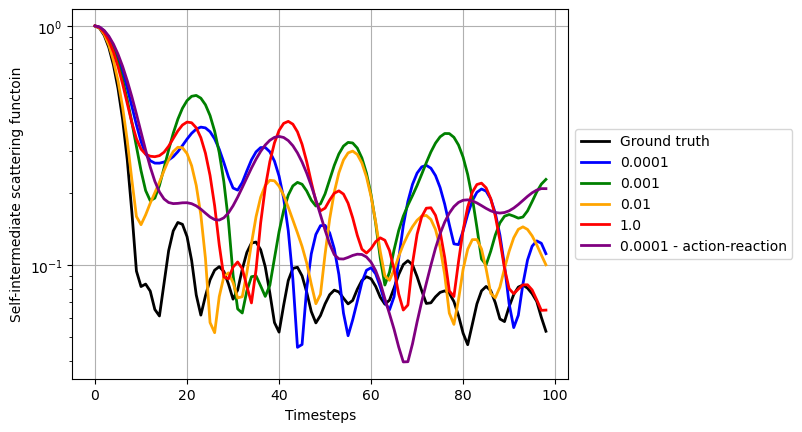

In [25]:
# plot of SSF

res_scat = []


ssf_mean = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_normal[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth')
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(l1)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    ssf_std = np.std(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    res_scat.append(ssf_mean)
    plt.semilogy(t, ssf_mean, color = colors[i], lw=2, label = str(l1[i]))
    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-simplest.png', bbox_inches='tight')
plt.show()

In [26]:
scat_gt = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)

for i in range(len(res_scat)):
    delta = (scat_gt - res_scat[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 0.020856016659305372 +- 0.024499791379454513
l1: 0.001 >>>> 0.03116668158989634 +- 0.03986349448334137
l1: 0.01 >>>> 0.008309595246866686 +- 0.011964850294647252
l1: 1.0 >>>> 0.02101537717622031 +- 0.027271615710026068
l1: 0.0001 - action-reaction >>>> 0.018541408532594138 +- 0.025399980269374692


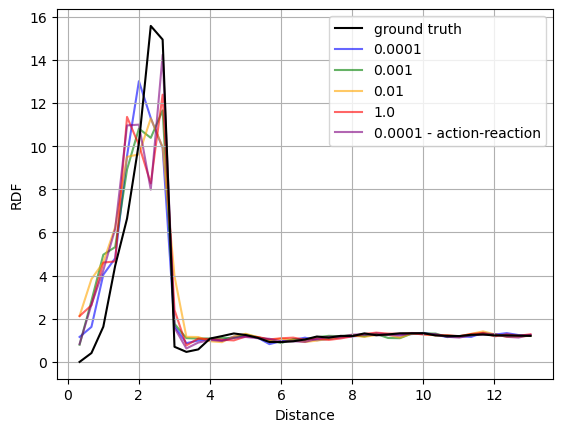

In [27]:
mean_res, std_res, r = RDF_base_normal
lim_rdf = 40

res_rdf = []


mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4)

for i in range(len(l1)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_normal[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    
    plt.plot(r, mean_res, color = colors[i], label = str(l1[i]), alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)
    
    res_rdf.append(mean_res)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-simplest.png')
plt.show()

In [28]:
mean_res, std_res, r = RDF_base_normal
mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
rdf_gt = np.mean(mean_res, axis = 0)

for i in range(len(res_rdf)):
    delta = (rdf_gt - res_rdf[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 9.176835251275376 +- 24.23979315711392
l1: 0.001 >>>> 8.38868826311502 +- 20.720972503898153
l1: 0.01 >>>> 7.961147547595303 +- 18.6340447324816
l1: 1.0 >>>> 8.453811132692048 +- 22.35388238223468
l1: 0.0001 - action-reaction >>>> 9.966830032251734 +- 27.44524333946875


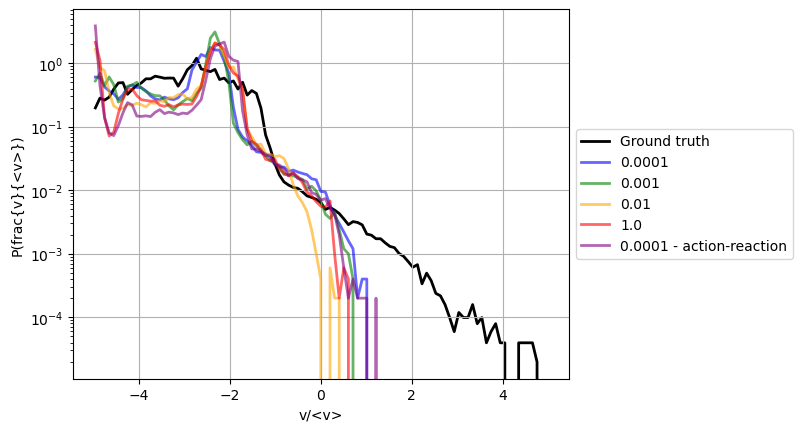

In [29]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)

res_magn_distr = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_normal[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    plt.semilogy(b[1:]-db/2,magn_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_distr.append(magn_base_mean)



plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-simplest.png', bbox_inches='tight')
plt.show()

In [30]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_distr)):
    delta = (magn_gt - res_magn_distr[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 0.057145637044232415 +- 0.171368548126601
l1: 0.001 >>>> 0.14843537605403273 +- 0.6454083001633588
l1: 0.01 >>>> 0.10759056997471445 +- 0.3365826940835489
l1: 1.0 >>>> 0.1364451422718906 +- 0.47284913858580147
l1: 0.0001 - action-reaction >>>> 0.25937493503693526 +- 1.3843456920333024


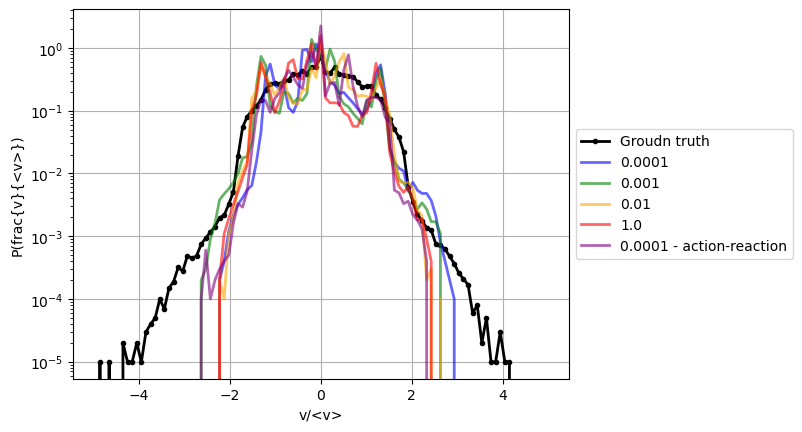

In [31]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)

res_magn_x = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Groudn truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_normal[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    plt.semilogy(b[1:]-db/2,x_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_x.append(x_base_mean)

    
plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-x-simplest.png', bbox_inches='tight')
plt.show()

In [32]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(x_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_x)):
    delta = (magn_gt - res_magn_x[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 0.018581568802414173 +- 0.059954927307684196
l1: 0.001 >>>> 0.02579759708160246 +- 0.09136259746604104
l1: 0.01 >>>> 0.012208566352691767 +- 0.04291008193023883
l1: 1.0 >>>> 0.02484360297112843 +- 0.08619995589509595
l1: 0.0001 - action-reaction >>>> 0.030254278643164326 +- 0.22464180291786806


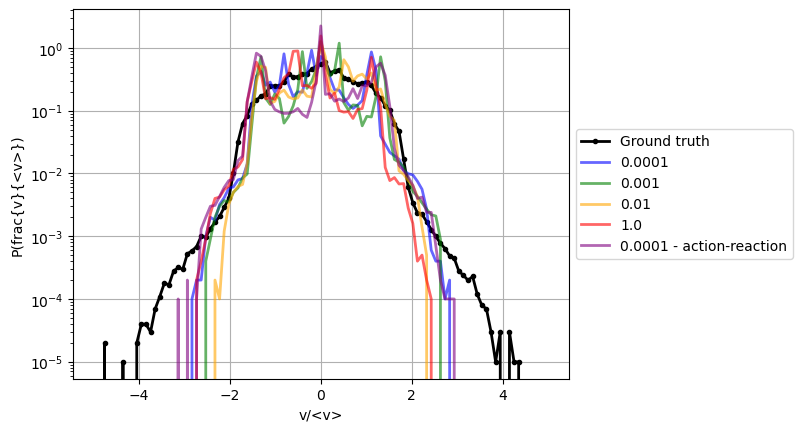

In [33]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)

res_magn_y = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_normal[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    plt.semilogy(b[1:]-db/2,y_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_y.append(y_base_mean)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-simplest.png', bbox_inches='tight')
plt.show()

In [34]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(y_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_y)):
    delta = (magn_gt - res_magn_y[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 0.014971086848535655 +- 0.05109988313469691
l1: 0.001 >>>> 0.025907241124630043 +- 0.08772361818386104
l1: 0.01 >>>> 0.014283789718678596 +- 0.05565464351999388
l1: 1.0 >>>> 0.02836028330317223 +- 0.1117691970943499
l1: 0.0001 - action-reaction >>>> 0.052751275877565076 +- 0.2924015476686155


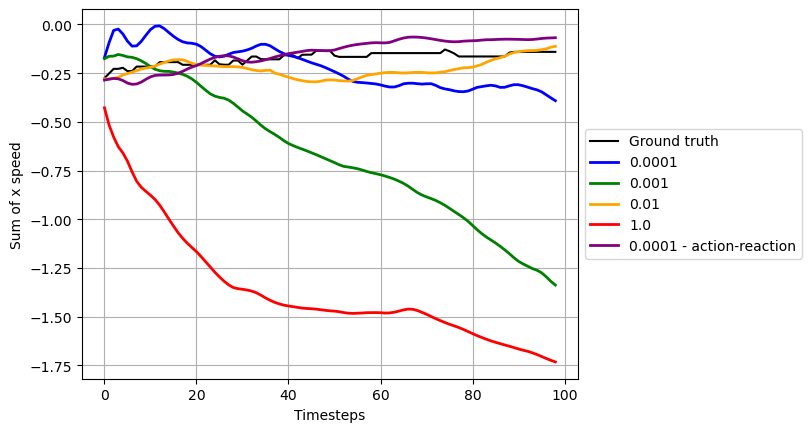

In [35]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(l1)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-simplest.png', bbox_inches='tight')
plt.show()

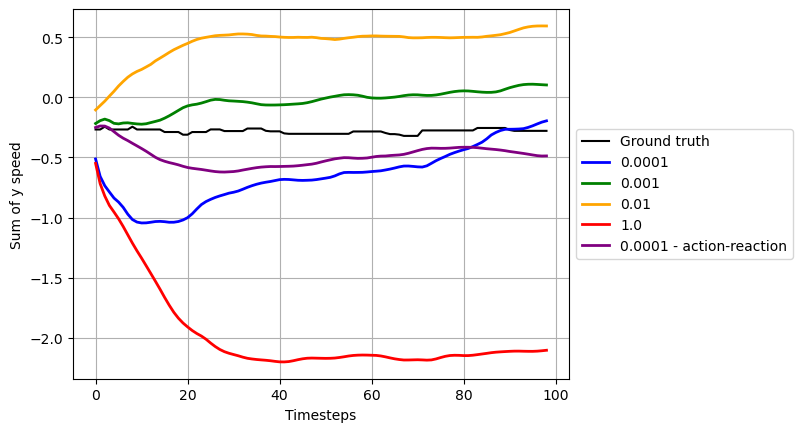

In [36]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(l1)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of y speed')


#plt.ylim([np.min(mean_sum[:liit_sum, 1])- 0.5, np.max(mean_sum[:liit_sum, 1])+ 0.5])

plt.savefig('speed-sum-y-simplest.png', bbox_inches='tight')
plt.show()

# =======================
# =======================

In [37]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 1000


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


#data_gt_1  = gen.get_mult_data(params1, NB_SIM)
#graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
#data_gt_list_1 = array2List(data_gt_1)


data_gt_2 = gen.get_mult_data(params2, NB_SIM)
graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
data_gt_list_2 = array2List(data_gt_2)

1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:23<00:00, 42.81it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:23<00:00, 43.13it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:24<00:00, 41.24it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:21<00:00, 45.97it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:22<00:00, 43.44it/s]


In [38]:
start = 250
length = 100

stop = start+length

In [39]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_noisy = stats.MSD_stat(data_gt_2[:, start:stop])
RDF_base_noisy  = stats.apply_rdf(data_gt_2[:, start:stop])
SCAT_base_noisy = stats.applySelfScattering(data_gt_2[:, start:stop])
DISTR_base_noisy = stats.apply_hist(data_gt_2, a, b)
SUM_base_noisy = stats.sumSpeeds(data_gt_2[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:01<00:00, 68.86it/s]


In [40]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
#p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:00,  2.68it/s]


In [41]:
MSD_list_noisy = []
RDF_list_noisy = []
SCAT_list_noisy = []
DISTR_list_noisy = []
SUM_list_noisy = []
MSE_rollout_noisy = []

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []




for i in tqdm(range(len(noisy_models_l1))):

    ## load model
    cfg = noisy_models_l1[i].cfg
    std_path = noisy_models_l1[i].path
    model = getModel(cfg, std_path)


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_2, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_2.copy()[:, start:stop])



    MSD_list_noisy.append(msd)
    RDF_list_noisy.append(rdf)
    SCAT_list_noisy.append(scat)
    DISTR_list_noisy.append(speed_distr)
    SUM_list_noisy.append(sum_speed)
    MSE_rollout_noisy.append(mse_roll)
    
    
    
    
    
    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))


  0%|          | 0/5 [00:00<?, ?it/s]

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 256.39it/s]

100%|██████████| 99/99 [00:00<00:00, 271.78it/s]

100%|██████████| 99/99 [00:00<00:00, 204.48it/s]

100%|██████████| 99/99 [00:00<00:00, 290.54it/s]

100%|██████████| 99/99 [00:00<00:00, 245.08it/s]

100%|██████████| 100/100 [00:01<00:00, 70.10it/s][A

100%|██████████| 100/100 [00:01<00:00, 72.45it/s][A

100%|██████████| 100/100 [00:01<00:00, 71.17it/s]

100%|██████████| 100/100 [00:01<00:00, 62.60it/s][A

100%|██████████| 100/100 [00:01<00:00, 67.06it/s][A

 45%|████▌     | 70/155 [00:47<01:01,  1.38it/s]


100%|██████████| 155/155 [02:24<00:00,  1.80it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 326.28it/s]

100%|██████████| 15/15 [00:00<00:00, 323.47it/s]

100%|██████████| 15/15 [00:00<00:00, 322.98it/s]

100%|██████████| 15/15 [00:00<00:00, 323.84it/s]

100%|██████████| 15/15 [00:00<00:00, 329.14it/s]

100%|██████████| 15/15 [00:00<00:00, 331.75it/s]

100%|██████████| 15/15 [00:00<00:00, 277.00it/s]

100%|██████████| 15/15 [00:00<00:00, 332.03it/s]

100%|██████████| 15/15 [00:00<00:00, 287.85it/s]

100%|██████████| 15/15 [00:00<00:00, 214.06it/s]

100%|██████████| 15/15 [00:00<00:00, 270.16it/s]

100%|██████████| 15/15 [00:00<00:00, 270.96it/s]

100%|██████████| 15/15 [00:00<00:00, 285.81it/s]

100%|██████████| 15/15 [00:00<00:00, 274.40it/s]

100%|██████████| 15/15 [00:00<00:00, 286.46it/s]

100%|██████████| 15/15 [00:00<00:00, 269.94it/s]

100%|██████████| 15/15 [00:00<00:00, 276.03it/s]

100%|██████████| 15/15 [00:00<00:00, 239.70it/s]



>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 252.54it/s]

100%|██████████| 99/99 [00:00<00:00, 284.98it/s]

100%|██████████| 99/99 [00:00<00:00, 249.62it/s]

100%|██████████| 99/99 [00:00<00:00, 273.92it/s]

100%|██████████| 99/99 [00:00<00:00, 282.41it/s]

100%|██████████| 100/100 [00:01<00:00, 68.37it/s][A

100%|██████████| 100/100 [00:01<00:00, 69.75it/s][A

100%|██████████| 100/100 [00:01<00:00, 71.50it/s][A

100%|██████████| 100/100 [00:01<00:00, 78.16it/s][A

100%|██████████| 100/100 [00:01<00:00, 77.33it/s][A

 47%|████▋     | 73/155 [00:51<00:54,  1.50it/s]


100%|██████████| 155/155 [02:35<00:00,  1.37it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 279.79it/s]

100%|██████████| 15/15 [00:00<00:00, 272.41it/s]

100%|██████████| 15/15 [00:00<00:00, 301.05it/s]

100%|██████████| 15/15 [00:00<00:00, 301.70it/s]

100%|██████████| 15/15 [00:00<00:00, 274.59it/s]

100%|██████████| 15/15 [00:00<00:00, 274.25it/s]

100%|██████████| 15/15 [00:00<00:00, 305.81it/s]

100%|██████████| 15/15 [00:00<00:00, 305.81it/s]

100%|██████████| 15/15 [00:00<00:00, 306.23it/s]

100%|██████████| 15/15 [00:00<00:00, 271.14it/s]

100%|██████████| 15/15 [00:00<00:00, 275.86it/s]

100%|██████████| 15/15 [00:00<00:00, 305.01it/s]

100%|██████████| 15/15 [00:00<00:00, 307.59it/s]

100%|██████████| 15/15 [00:00<00:00, 270.36it/s]

100%|██████████| 15/15 [00:00<00:00, 276.83it/s]

100%|██████████| 15/15 [00:00<00:00, 284.42it/s]

100%|██████████| 15/15 [00:00<00:00, 290.93it/s]

100%|██████████| 15/15 [00:00<00:00, 282.15it/s]



>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 273.09it/s]

100%|██████████| 99/99 [00:00<00:00, 246.56it/s]

100%|██████████| 99/99 [00:00<00:00, 324.41it/s]

100%|██████████| 99/99 [00:00<00:00, 333.26it/s]

100%|██████████| 99/99 [00:00<00:00, 316.33it/s]

100%|██████████| 100/100 [00:01<00:00, 66.22it/s][A

100%|██████████| 100/100 [00:01<00:00, 63.37it/s]

100%|██████████| 100/100 [00:01<00:00, 63.57it/s]

100%|██████████| 100/100 [00:01<00:00, 61.18it/s]

100%|██████████| 100/100 [00:01<00:00, 63.10it/s][A

 43%|████▎     | 66/155 [01:00<01:28,  1.00it/s]


100%|██████████| 155/155 [02:10<00:00,  1.70it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 283.60it/s]

100%|██████████| 15/15 [00:00<00:00, 271.98it/s]

100%|██████████| 15/15 [00:00<00:00, 282.24it/s]

100%|██████████| 15/15 [00:00<00:00, 287.42it/s]

100%|██████████| 15/15 [00:00<00:00, 290.37it/s]

100%|██████████| 15/15 [00:00<00:00, 287.92it/s]

100%|██████████| 15/15 [00:00<00:00, 287.19it/s]

100%|██████████| 15/15 [00:00<00:00, 264.62it/s]

100%|██████████| 15/15 [00:00<00:00, 287.25it/s]

100%|██████████| 15/15 [00:00<00:00, 271.47it/s]

100%|██████████| 15/15 [00:00<00:00, 283.95it/s]

100%|██████████| 15/15 [00:00<00:00, 294.27it/s]

100%|██████████| 15/15 [00:00<00:00, 310.81it/s]

100%|██████████| 15/15 [00:00<00:00, 312.32it/s]

100%|██████████| 15/15 [00:00<00:00, 280.44it/s]

100%|██████████| 15/15 [00:00<00:00, 275.23it/s]

100%|██████████| 15/15 [00:00<00:00, 304.21it/s]

100%|██████████| 15/15 [00:00<00:00, 308.65it/s]



>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 260.89it/s]

100%|██████████| 99/99 [00:00<00:00, 260.89it/s]

100%|██████████| 99/99 [00:00<00:00, 282.38it/s]

100%|██████████| 99/99 [00:00<00:00, 312.06it/s]

100%|██████████| 99/99 [00:00<00:00, 327.84it/s]

100%|██████████| 100/100 [00:01<00:00, 90.73it/s][A

100%|██████████| 100/100 [00:01<00:00, 87.39it/s][A

100%|██████████| 100/100 [00:01<00:00, 85.70it/s][A

100%|██████████| 100/100 [00:01<00:00, 82.96it/s][A

100%|██████████| 100/100 [00:01<00:00, 85.36it/s][A

 54%|█████▍    | 84/155 [00:52<00:46,  1.53it/s]


100%|██████████| 155/155 [01:43<00:00,  1.69it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 303.38it/s]

100%|██████████| 15/15 [00:00<00:00, 309.43it/s]

100%|██████████| 15/15 [00:00<00:00, 280.17it/s]

100%|██████████| 15/15 [00:00<00:00, 273.92it/s]

100%|██████████| 15/15 [00:00<00:00, 310.06it/s]

100%|██████████| 15/15 [00:00<00:00, 309.24it/s]

100%|██████████| 15/15 [00:00<00:00, 310.69it/s]

100%|██████████| 15/15 [00:00<00:00, 272.07it/s]

100%|██████████| 15/15 [00:00<00:00, 274.72it/s]

100%|██████████| 15/15 [00:00<00:00, 286.12it/s]

100%|██████████| 15/15 [00:00<00:00, 279.52it/s]

100%|██████████| 15/15 [00:00<00:00, 279.48it/s]

100%|██████████| 15/15 [00:00<00:00, 265.13it/s]

100%|██████████| 15/15 [00:00<00:00, 282.75it/s]

100%|██████████| 15/15 [00:00<00:00, 284.17it/s]

100%|██████████| 15/15 [00:00<00:00, 280.04it/s]

100%|██████████| 15/15 [00:00<00:00, 279.28it/s]

100%|██████████| 15/15 [00:00<00:00, 286.76it/s]



>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 327.70it/s]

100%|██████████| 99/99 [00:00<00:00, 299.96it/s]

100%|██████████| 99/99 [00:00<00:00, 264.02it/s]

100%|██████████| 99/99 [00:00<00:00, 254.32it/s]

100%|██████████| 99/99 [00:00<00:00, 263.69it/s]

100%|██████████| 100/100 [00:01<00:00, 86.88it/s][A

100%|██████████| 100/100 [00:01<00:00, 84.19it/s][A

100%|██████████| 100/100 [00:01<00:00, 82.34it/s]

100%|██████████| 100/100 [00:01<00:00, 79.73it/s][A

100%|██████████| 100/100 [00:01<00:00, 80.02it/s][A

 52%|█████▏    | 81/155 [00:47<00:41,  1.80it/s]


100%|██████████| 155/155 [01:47<00:00,  1.63it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 313.53it/s]

100%|██████████| 15/15 [00:00<00:00, 320.89it/s]

100%|██████████| 15/15 [00:00<00:00, 324.44it/s]

100%|██████████| 15/15 [00:00<00:00, 312.36it/s]

100%|██████████| 15/15 [00:00<00:00, 319.82it/s]

100%|██████████| 15/15 [00:00<00:00, 328.21it/s]

100%|██████████| 15/15 [00:00<00:00, 303.69it/s]

100%|██████████| 15/15 [00:00<00:00, 335.50it/s]

100%|██████████| 15/15 [00:00<00:00, 319.84it/s]

100%|██████████| 15/15 [00:00<00:00, 280.95it/s]

100%|██████████| 15/15 [00:00<00:00, 320.03it/s]

100%|██████████| 15/15 [00:00<00:00, 298.65it/s]

100%|██████████| 15/15 [00:00<00:00, 325.45it/s]

100%|██████████| 15/15 [00:00<00:00, 311.27it/s]

100%|██████████| 15/15 [00:00<00:00, 259.19it/s]

100%|██████████| 15/15 [00:00<00:00, 276.54it/s]

100%|██████████| 15/15 [00:00<00:00, 214.44it/s]

100%|██████████| 15/15 [00:00<00:00, 248.82it/s]



In [42]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.0048671221201895855, 0.0035576252838481447, 0.005347869848023733, 0.005253448315601003, 0.001441005625322055]
errors std ==> [0.00470067861809693, 0.003489680148813875, 0.004563126405120394, 0.004872159220599784, 0.0017994357092934719]
angle_error ==>  [0.13613826, 0.1258733, 0.10881548, 0.15234582, 0.11489865]
angle_std std ==> [0.13613826, 0.1258733, 0.10881548, 0.15234582, 0.11489865]
norm_errors_list ==>  [0.00755876861512661, 0.005621500313282013, 0.007967830635607243, 0.008082108572125435, 0.0014044828712940216]
norm_errors_std_list std ==> [0.005331546461683052, 0.003948523430637222, 0.0055884835149455836, 0.005578008155368625, 0.0020574687374023885]
sim_error_list ==>  [0.0907724049072863, 0.06659596505202324, 0.09525025082709646, 0.09343701492242411, 0.03606402402215848]
sim_error_std_list std ==> [0.002136484280610475, 0.0022181236644205882, 0.00207303965385581, 0.0022203060974764865, 0.002623259865537567]


In [43]:
l1 = [noisy_models_l1[i].l1 for i in range(len(noisy_models_l1))]

print(l1)

[0.0001, 0.001, 0.01, 1.0, None]


In [44]:
l1[-1] = '0.0001 - action-reaction'
colors = ['blue', 'green', 'orange', 'red', 'purple']


In [45]:
limit_msd = 99
limit_scat = 99

In [46]:
print(l1)

[0.0001, 0.001, 0.01, 1.0, '0.0001 - action-reaction']


(5, 99)
(5, 99)
(5, 99)
(5, 99)
(5, 99)


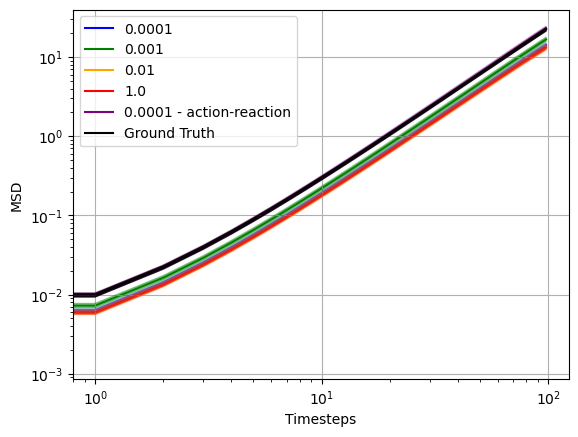

In [47]:
res_msd = []

# plot of MSD


for i in range(len(l1)):
    print(MSD_list_noisy[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], zorder = 1, label = str(l1[i]))
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_noisy[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.8, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend()
plt.savefig('MSD-simplest-noisy.png')



In [48]:
msd_gt = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)

In [49]:
for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 13.500054729336709 +- 17.94466218812908
l1: 0.001 >>>> 6.446120983914229 +- 8.548632762093233
l1: 0.01 >>>> 16.252362513778177 +- 21.629577501336616
l1: 1.0 >>>> 17.183739170489005 +- 22.92918121456554
l1: 0.0001 - action-reaction >>>> 0.09833917042284498 +- 0.12706578812144909


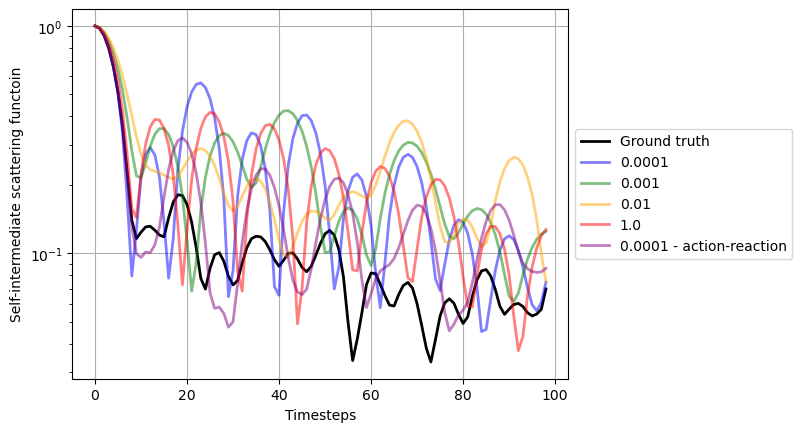

In [50]:
# plot of SSF

res_scat = []



ssf_mean = np.mean(SCAT_base_noisy[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_noisy[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth')
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(l1)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    ssf_std = np.std(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    plt.semilogy(t, ssf_mean, color = colors[i], lw=2, label = str(l1[i]), alpha = 0.5)
    res_scat.append(ssf_mean)
    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [51]:
scat_gt = np.mean(SCAT_base_noisy[:, :limit_scat], axis = 0)

for i in range(len(res_scat)):
    delta = (scat_gt - res_scat[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 0.024996053003162516 +- 0.04522518553677544
l1: 0.001 >>>> 0.022875775864066156 +- 0.026767099650647327
l1: 0.01 >>>> 0.020031346913892467 +- 0.024390354047067676
l1: 1.0 >>>> 0.018531684845677607 +- 0.025407602834534825
l1: 0.0001 - action-reaction >>>> 0.004266599634913228 +- 0.005620158528538964


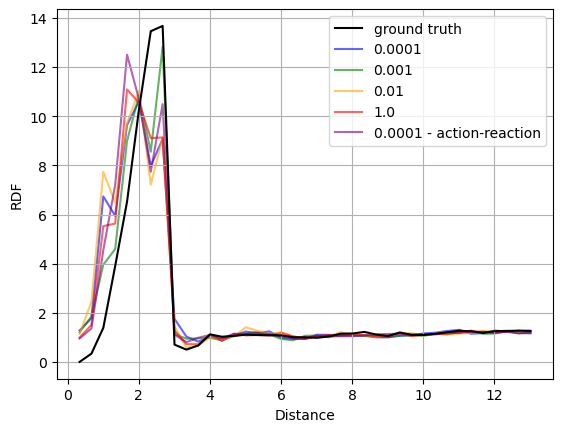

In [52]:
mean_res, std_res, r = RDF_base_noisy
lim_rdf = 40

res_rdf = []


mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4)

for i in range(len(l1)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_noisy[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    
    plt.plot(r, mean_res, color = colors[i], label = str(l1[i]), alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)
    
    res_rdf.append(mean_res)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-simplest-noisy.png')
plt.show()

In [53]:
mean_res, std_res, r = RDF_base_noisy
mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
rdf_gt = np.mean(mean_res, axis = 0)

for i in range(len(res_rdf)):
    delta = (rdf_gt - res_rdf[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 7.1605880836754 +- 16.40178086158238
l1: 0.001 >>>> 8.28919141163722 +- 22.73621091851029
l1: 0.01 >>>> 7.594722524695022 +- 17.377910126796735
l1: 1.0 >>>> 7.905420187483039 +- 19.034572962714464
l1: 0.0001 - action-reaction >>>> 8.95304680474429 +- 22.90062910218612


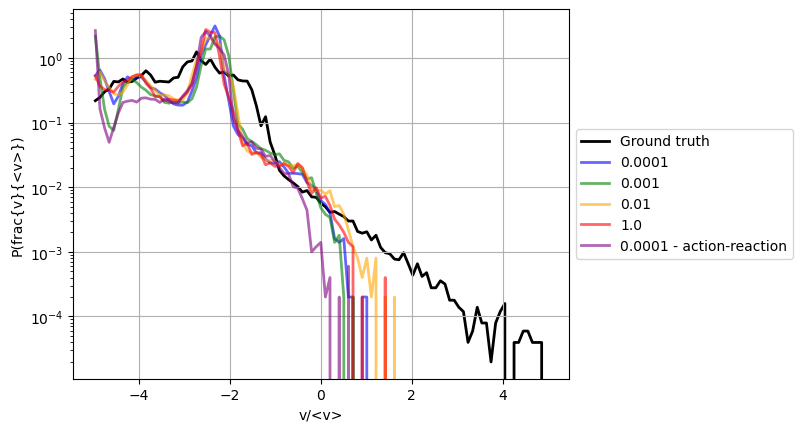

In [54]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)

res_magn_distr = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_noisy[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    plt.semilogy(b[1:]-db/2,magn_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_distr.append(magn_base_mean)



plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [55]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(magn_base, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_distr)):
    delta = (magn_gt - res_magn_distr[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 0.1396678026976867 +- 0.6477809970938002
l1: 0.001 >>>> 0.14264570153701026 +- 0.5192721915583907
l1: 0.01 >>>> 0.06816433248375411 +- 0.2356946081598084
l1: 1.0 >>>> 0.12164521322042514 +- 0.5355039755943621
l1: 0.0001 - action-reaction >>>> 0.16749932078904428 +- 0.6911590898888447


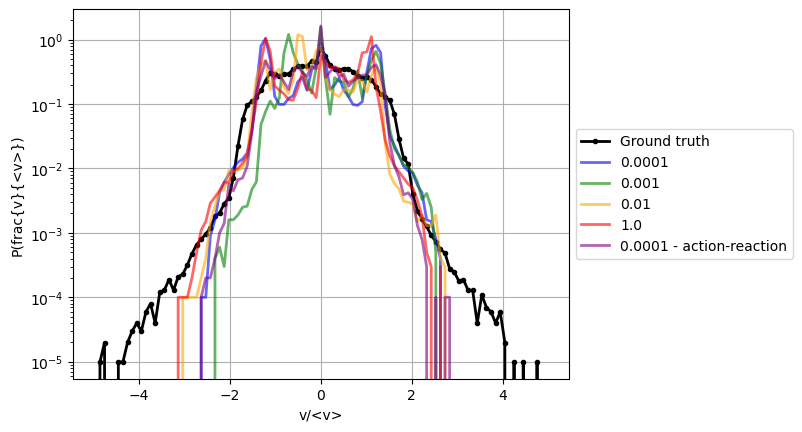

In [56]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)

res_magn_x = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_noisy[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    plt.semilogy(b[1:]-db/2,x_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    
    res_magn_x.append(x_base_mean)

    
plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-x-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [57]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(x_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_x)):
    delta = (magn_gt - res_magn_x[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 0.02617415391924551 +- 0.09138861168373856
l1: 0.001 >>>> 0.02770042597534916 +- 0.11118269396660418
l1: 0.01 >>>> 0.019023487990950858 +- 0.08424988638236651
l1: 1.0 >>>> 0.02502576765532047 +- 0.10391690730163687
l1: 0.0001 - action-reaction >>>> 0.012189821436246372 +- 0.0818893845115325


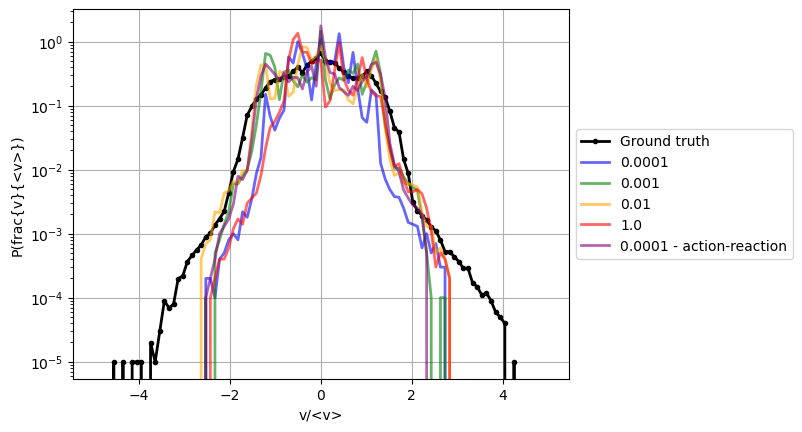

In [58]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)

res_magn_y = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_noisy[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    plt.semilogy(b[1:]-db/2,y_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_y.append(y_base_mean)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [59]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(y_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_y)):
    delta = (magn_gt - res_magn_y[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 >>>> 0.024133878070831 +- 0.10051653813861504
l1: 0.001 >>>> 0.019298526783179674 +- 0.07201838716202477
l1: 0.01 >>>> 0.011344623070375856 +- 0.03386920461830928
l1: 1.0 >>>> 0.027805937475690372 +- 0.11255391512960299
l1: 0.0001 - action-reaction >>>> 0.01802211506418803 +- 0.12137910083902007


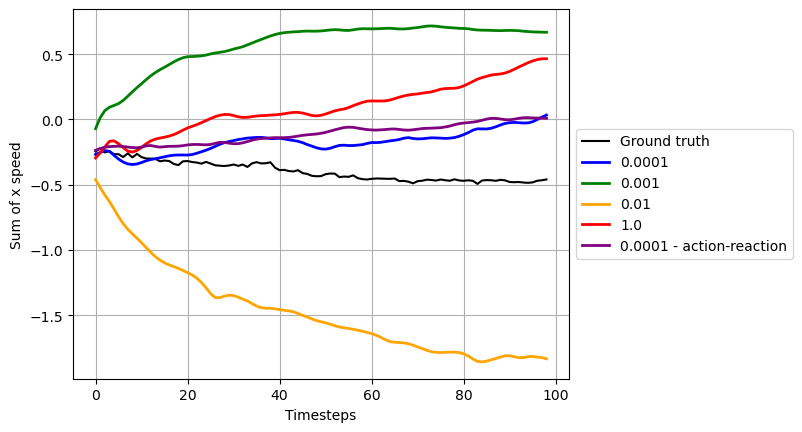

In [60]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(l1)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-simplest-noisy.png', bbox_inches='tight')
plt.show()

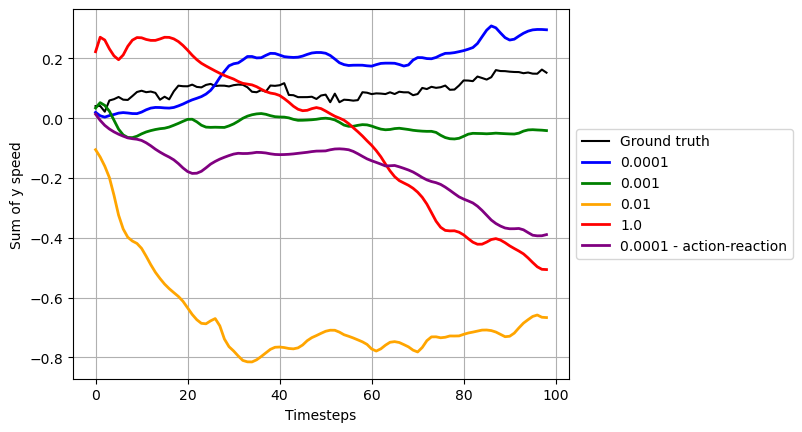

In [61]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(l1)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of y speed')


#plt.ylim([np.min(mean_sum[:liit_sum, 1])- 0.5, np.max(mean_sum[:liit_sum, 1])+ 0.5])

plt.savefig('speed-sum-y-simplest-noisy.png', bbox_inches='tight')
plt.show()